In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import warnings
import missingno as msno        # visualization missing
import seaborn as sns
from scipy import stats

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/titanic/gender_submission.csv
/kaggle/input/titanic/test.csv
/kaggle/input/titanic/train.csv


### Creación de funciones


In [2]:

# Funciones para el Univariante
def analisisCategoricas(df, variable):
    frecuencia_absoluta = pd.DataFrame(df[variable].value_counts(dropna = False))
    frecuencia_absoluta.columns = ['FREC_ABS'] 
    #display(frecuencia_absoluta)
    frecuencia_relativa = pd.DataFrame(df[variable].value_counts(normalize = True, dropna = False))
    frecuencia_relativa.columns = ['FREC_REL'] 
    #display(frecuencia_relativa)
    display(pd.concat([frecuencia_absoluta,frecuencia_relativa], axis = 1))

def analisisNumericas(df, variable):
    fig = plt.figure()
    ax = df[variable].plot(kind='hist',grid=True)
    ax.set_title(variable)
    plt.show();
    ax = df[variable].plot(kind='box',grid=True)
    ax.set_title(variable)
    plt.show();

def analizadorNulos(data):
    
    if data.isnull().any().any():
        view_info = pd.DataFrame(pd.concat([data.isnull().any(), data.isnull().sum(), 
                                            round(data.isnull().sum() / qFilas * 100, 2), data.dtypes], axis=1))
        view_info.columns = ['Nulos', 'Cantidad', 'PCT_Nulos', 'Tipo_Dato']
        display(view_info[view_info['Cantidad'] > 0])
    else:
        print("No existen Nulos")

# Funciones para el Bivariante
def discretizarVariable(df, variable, qCortes):

    df[variable + '_D'] = pd.qcut(df[variable], qCortes, duplicates='drop')
    df[variable + '_D'] = df[variable + '_D'].cat.add_categories('Nulo')
    df.loc[df[variable + '_D'].isna(), variable + '_D'] = 'Nulo'

    return df

def analisisBivariante(df, variable, target):
    
    prueba = pd.concat([df.groupby(variable).sum()[[target]].sort_index(), df[variable].value_counts()], axis = 1)
    prueba['PCT_' + variable] = prueba[target] / prueba[variable]
    fig = plt.figure()
    ax = prueba[variable].plot(kind='bar',grid=True)
    ax.set_title(variable)
    ax2 = ax.twinx()
    ax2.plot(prueba['PCT_' + variable].values, linestyle='-', linewidth=2.0,color='red')
    rects = ax.patches
    labels = prueba[variable]
    for rect, label in zip(rects, labels):
        height = rect.get_height() 
        ax.text(rect.get_x() + rect.get_width()/2, height + 5, label, ha='center', va='bottom')
        #ax2.text(rect2.get_x() + rect2.get_width()/2, label, label, ha='center', va='bottom')
    labels2 = prueba['PCT_' + variable]
    for rect, label2 in zip(rects, labels2):
        ax2.text(rect.get_x() + rect.get_width()/2, label2 + 0.005, "%d%%" % round(label2*100,2), ha='center', va='bottom')
    plt.show();
    #plt.text(0.9, 0.2, 'cos')

In [3]:
train_data = pd.read_csv("../input/titanic/train.csv")
train_data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [4]:
test_data = pd.read_csv("../input/titanic/test.csv")
test_data.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


In [5]:
PassengerId_test = test_data['PassengerId'].copy()

In [6]:
train_data.describe(include = 'all')

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
count,891.000000,891.000000,891.000000,891,891,714.000000,891.000000,891.000000,891,891.000000,204,889
unique,NaN,NaN,NaN,891,2,NaN,NaN,NaN,681,NaN,147,3
top,NaN,NaN,NaN,"Endres, Miss. Caroline Louise",male,NaN,NaN,NaN,1601,NaN,C23 C25 C27,S
freq,NaN,NaN,NaN,1,577,NaN,NaN,NaN,7,NaN,4,644
mean,446.000000,0.383838,2.308642,NaN,NaN,29.699118,0.523008,0.381594,NaN,32.204208,NaN,NaN
std,257.353842,0.486592,0.836071,NaN,NaN,14.526497,1.102743,0.806057,NaN,49.693429,NaN,NaN
min,1.000000,0.000000,1.000000,NaN,NaN,0.420000,0.000000,0.000000,NaN,0.000000,NaN,NaN
25%,223.500000,0.000000,2.000000,NaN,NaN,20.125000,0.000000,0.000000,NaN,7.910400,NaN,NaN
50%,446.000000,0.000000,3.000000,NaN,NaN,28.000000,0.000000,0.000000,NaN,14.454200,NaN,NaN
75%,668.500000,1.000000,3.000000,NaN,NaN,38.000000,1.000000,0.000000,NaN,31.000000,NaN,NaN


## Analisis Univariante


In [7]:
# Generar las variables dimensiones
qFilas, qColumnas = train_data.shape
qFilasT, qColumnasT = test_data.shape
print("La cantidad de filas en train: ", qFilas, ", en test:", qFilasT)
print("La cantidad de columnas en train:", qColumnas, ", en test:", qColumnasT)

La cantidad de filas en train:  891 , en test: 418
La cantidad de columnas en train: 12 , en test: 11


In [8]:
train_data['Survived'].value_counts(dropna=False, normalize=True)

0    0.616162
1    0.383838
Name: Survived, dtype: float64

In [9]:
train_data.columns


Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked'],
      dtype='object')

In [10]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [11]:
varCategoricas = ['Pclass', 'Name', 'Sex', 'Ticket', 'Cabin', 'Embarked']
varNumericas = ['Age', 'SibSp', 'Parch', 'Fare']
varOtras = []

## Analisis Univariante
## Analisis Univariante - Categoricas


In [12]:
#for categorica in list(varCategoricas):
 #   print("------------------------",categorica,"------------------------")
 #   analisisCategoricas(train_data,categorica)

In [13]:
#for col in varNumericas:
 #   analisisNumericas(train_data,col)

## Analisis Bivariante


In [14]:
target = 'Survived'

In [15]:
# Datos agrupados por el TARGET
grouped_data = train_data.groupby('Survived')

In [16]:
# Estadísticas para todas las columnas numéricas por TARGET
grouped_data.describe(include = "all")
# Regresa la media de cada columna numérica por TARGET
grouped_data.median()

,PassengerId,Pclass,Age,SibSp,Parch,Fare
Survived,,,,,,
0,455.0,3.0,28.0,0.0,0.0,10.5
1,439.5,2.0,28.0,0.0,0.0,26.0


In [17]:
# Discretizar Variables Numéricas:
#for col in varNumericas:
#    discretizarVariable(train_data, col, 10)

In [18]:
# Visualización Variables Numéricas:
#for col in varCategoricas + [x + '_D' for x in varNumericas]:
#    analisisBivariante(train_data, col, target)

In [19]:
# Visualización de Variables Categoricas:
#for col in varCategoricas:
#    analisisBivariante(train_data, col, target)

## Analisis de Nulos

In [20]:
# Se crea una función que muestra la cantidad de nulos 
analizadorNulos(train_data), analizadorNulos(test_data)

,Nulos,Cantidad,PCT_Nulos,Tipo_Dato
Age,True,177,19.87,float64
Cabin,True,687,77.10,object
Embarked,True,2,0.22,object


,Nulos,Cantidad,PCT_Nulos,Tipo_Dato
Age,True,86,9.65,float64
Fare,True,1,0.11,float64
Cabin,True,327,36.70,object


(None, None)

In [21]:
#############################################
#IMPUTO VARIABLES CATEGORICAS POR LA MODA

for col in varCategoricas:
    mode_ = train_data[col].mode()[0]
    train_data[col].fillna(mode_, inplace = True)
    test_data[col].fillna(mode_, inplace = True)

    

In [22]:
#############################################
#IMPUTO VARIABLES NUMÉRICAS POR LA MEDIANA

for col in varNumericas:
    median_ = train_data[col].median()
    train_data[col].fillna(median_, inplace = True)
    test_data[col].fillna(median_, inplace = True)
    

    

## Preprocesamiento

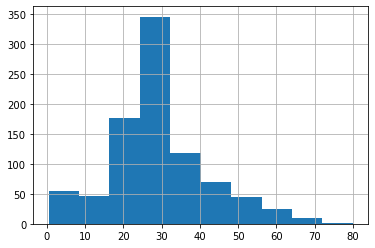

In [23]:
train_data['Age'].hist()

In [24]:
def _range_edad(_):
    if _ < 0:
        return 'sin edad'
    elif _ < 10:
        return 'ninno'
    elif _ < 20:
        return 'adolescente'
    elif _ < 30:
        return 'joven'
    elif _ < 40:
        return 'adulto'
    elif _ < 50:
        return 'adultomayor'
    else:
        return 'anciano'

train_data['range_edad'] = train_data['Age'].apply(_range_edad)
test_data['range_edad'] = test_data['Age'].apply(_range_edad)

In [25]:
#Rango de edades
# [0-10] = Niños
# [11-20] = Adolescente
# [21-40] = Adulto
# [41-60] = Adulto_1
# [61-65] = Anciano
# [66-70] = Anciano_1
# [71-75] = Anciano_2
# [76-80] = Anciano_3

rango = [0,10,20,30,40,50,80]
names = ['1','2','3','4','5','6']
train_data['Edad'] = pd.cut(train_data['Age'], rango, labels = names)
test_data['Edad'] = pd.cut(test_data['Age'], rango, labels = names)

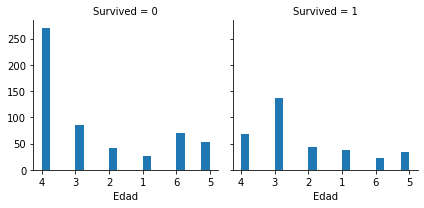

In [26]:
g = sns.FacetGrid(train_data, col='Survived')
g.map(plt.hist, 'Edad', bins=20)

In [27]:
train_data['Pclass'] = train_data['Pclass'].astype('str')
test_data['Pclass'] = test_data['Pclass'].astype('str')

In [28]:
train_data['Sex'] = train_data['Sex'].astype('str')
test_data['Sex'] = test_data['Sex'].astype('str')

In [29]:
#train_data = train_data.drop(['PassengerId','Age','Ticket'], axis=1)
#test_data1 = test_data.drop(['PassengerId','Age','Ticket'], axis=1)

Train: Age con 177 nulos, Cabin con 687 nulos y Embarked con 2 nulos. Cabin contiene el 77% de su data nula.



Test: Age con 86 nulos, Fare con 1 nulo y Cabin con 327 nulos. Cabin contiene el 78% de su data nula.

###### La variable 'Cabin' no aporta mucho por la cantidad de nulos, debemos ver si influencia en las demás variables

## 5. Feature Enginner

In [30]:
train_data.Cabin

0      B96 B98
1          C85
2      B96 B98
3         C123
4      B96 B98
        ...   
886    B96 B98
887        B42
888    B96 B98
889       C148
890    B96 B98
Name: Cabin, Length: 891, dtype: object

In [31]:
train_data.columns

Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked', 'range_edad', 'Edad'],
      dtype='object')

In [32]:
#LOS NOMBRES CON PARENTESIS TIENEN PARENTESCO
train_data['Mr'] = train_data['Name'].apply(lambda _: int('Mr' in _))
test_data['Mr'] = test_data['Name'].apply(lambda _: int('Mr' in _))

train_data['Mrs'] = train_data['Name'].apply(lambda _: int('Mrs' in _))
test_data['Mrs'] = test_data['Name'].apply(lambda _: int('Mrs' in _))

train_data['Miss'] = train_data['Name'].apply(lambda _: int('Miss' in _))
test_data['Miss'] = test_data['Name'].apply(lambda _: int('Miss' in _))

train_data['Dr'] = train_data['Name'].apply(lambda _: int('Dr' in _))
test_data['Dr'] = test_data['Name'].apply(lambda _: int('Dr' in _))

In [33]:
train_data['alone'] = train_data[['SibSp', 'Parch']].apply(lambda _: 1 if _[0] == 0 and _[1] == 0 else 0, axis=1)
test_data['alone'] = test_data[['SibSp', 'Parch']].apply(lambda _: 1 if _[0] == 0 and _[1] == 0 else 0, axis=1)

In [34]:
train_data['total_family'] = train_data['SibSp'] + train_data['Parch']
test_data['total_family'] = test_data['SibSp'] + test_data['Parch']

In [35]:
train_data['family_greater_than_3'] = train_data[['SibSp', 'Parch']].apply(lambda _: 1 if _[0] + _[1] > 3 else 0, axis=1)
test_data['family_greater_than_3'] = test_data[['SibSp', 'Parch']].apply(lambda _: 1 if _[0] + _[1] > 3 else 0, axis=1)

In [36]:
train_data['sex_class'] = train_data['Sex'] + '_' + train_data['Pclass'].astype(str)
test_data['sex_class'] = test_data['Sex'] + '_' + test_data['Pclass'].astype(str)

In [37]:
train_data['Cabin'].unique()

array(['B96 B98', 'C85', 'C123', 'E46', 'G6', 'C103', 'D56', 'A6',
       'C23 C25 C27', 'B78', 'D33', 'B30', 'C52', 'B28', 'C83', 'F33',
       'F G73', 'E31', 'A5', 'D10 D12', 'D26', 'C110', 'B58 B60', 'E101',
       'F E69', 'D47', 'B86', 'F2', 'C2', 'E33', 'B19', 'A7', 'C49', 'F4',
       'A32', 'B4', 'B80', 'A31', 'D36', 'D15', 'C93', 'C78', 'D35',
       'C87', 'B77', 'E67', 'B94', 'C125', 'C99', 'C118', 'D7', 'A19',
       'B49', 'D', 'C22 C26', 'C106', 'C65', 'E36', 'C54',
       'B57 B59 B63 B66', 'C7', 'E34', 'C32', 'B18', 'C124', 'C91', 'E40',
       'T', 'C128', 'D37', 'B35', 'E50', 'C82', 'E10', 'E44', 'A34',
       'C104', 'C111', 'C92', 'E38', 'D21', 'E12', 'E63', 'A14', 'B37',
       'C30', 'D20', 'B79', 'E25', 'D46', 'B73', 'C95', 'B38', 'B39',
       'B22', 'C86', 'C70', 'A16', 'C101', 'C68', 'A10', 'E68', 'B41',
       'A20', 'D19', 'D50', 'D9', 'A23', 'B50', 'A26', 'D48', 'E58',
       'C126', 'B71', 'B51 B53 B55', 'D49', 'B5', 'B20', 'F G63',
       'C62 C64', 'E24

In [38]:
train_data['words_in_name'] = train_data['Name'].apply(lambda _: len(_.split()))
test_data['words_in_name'] = test_data['Name'].apply(lambda _: len(_.split()))

In [39]:
train_data.shape, test_data.shape

((891, 23), (418, 22))

## Dumming de variables

In [40]:
train_data.columns

Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked', 'range_edad', 'Edad',
       'Mr', 'Mrs', 'Miss', 'Dr', 'alone', 'total_family',
       'family_greater_than_3', 'sex_class', 'words_in_name'],
      dtype='object')

In [41]:
train_data.dtypes

PassengerId                 int64
Survived                    int64
Pclass                     object
Name                       object
Sex                        object
Age                       float64
SibSp                       int64
Parch                       int64
Ticket                     object
Fare                      float64
Cabin                      object
Embarked                   object
range_edad                 object
Edad                     category
Mr                          int64
Mrs                         int64
Miss                        int64
Dr                          int64
alone                       int64
total_family                int64
family_greater_than_3       int64
sex_class                  object
words_in_name               int64
dtype: object

In [42]:
def detect_share_ticket(data, col_analysis, new_column):
    _g = data.groupby(by=[col_analysis]).agg({
        'PassengerId': 'size',
    }).reset_index()
    _g[new_column] = _g['PassengerId'].apply(lambda _: 1 if _ > 1 else 0)

    data = data.merge(_g.drop(['PassengerId'], axis=1), on=col_analysis, how='left')
    del _g
    return data

train_data = detect_share_ticket(train_data, 'Ticket', 'shared_ticket')
test_data = detect_share_ticket(test_data, 'Ticket', 'shared_ticket')

In [43]:
train_data = detect_share_ticket(train_data, 'Cabin', 'shared_cabin')
test_data = detect_share_ticket(test_data, 'Cabin', 'shared_cabin')

In [44]:
train_data['Cabin'].fillna(value = 'x', inplace =True)
test_data['Cabin'].fillna(value = 'x', inplace =True)
train_data['Cabin'] = train_data['Cabin'].apply(lambda x: x[0])
test_data['Cabin'] = test_data['Cabin'].apply(lambda x: x[0])

In [45]:
train_data = train_data.drop(['PassengerId','Name','Ticket', 'sex_class'], axis=1)
test_data = test_data.drop(['PassengerId','Name','Ticket', 'sex_class'], axis=1)

In [46]:

df_train = train_data.copy()
df_test = test_data.copy()


In [47]:

#df_train = pd.get_dummies(df_train, columns = ['Sex'], drop_first=True)
#df_test = pd.get_dummies(df_test, columns = ['Sex'], drop_first=True)

#df_train.head()

In [48]:
df_train.shape, df_test.shape

((891, 21), (418, 20))

In [49]:

df_train['Pclass'] = df_train['Pclass'].astype(str)
df_test['Pclass'] = df_test['Pclass'].astype(str)

df_train = pd.get_dummies(df_train, drop_first=False)
df_test = pd.get_dummies(df_test, drop_first=False)

df_train.head()

,Survived,Age,SibSp,Parch,Fare,Mr,Mrs,Miss,Dr,alone,...,range_edad_adultomayor,range_edad_anciano,range_edad_joven,range_edad_ninno,Edad_1,Edad_2,Edad_3,Edad_4,Edad_5,Edad_6
0,0,22.0,1,0,7.2500,1,0,0,0,0,...,0,0,1,0,0,0,1,0,0,0
1,1,38.0,1,0,71.2833,1,1,0,0,0,...,0,0,0,0,0,0,0,1,0,0
2,1,26.0,0,0,7.9250,0,0,1,0,1,...,0,0,1,0,0,0,1,0,0,0
3,1,35.0,1,0,53.1000,1,1,0,0,0,...,0,0,0,0,0,0,0,1,0,0
4,0,35.0,0,0,8.0500,1,0,0,0,1,...,0,0,0,0,0,0,0,1,0,0


In [50]:
df_train.shape, df_test.shape

((891, 43), (418, 41))

In [51]:
print(df_train.columns)

Index(['Survived', 'Age', 'SibSp', 'Parch', 'Fare', 'Mr', 'Mrs', 'Miss', 'Dr',
       'alone', 'total_family', 'family_greater_than_3', 'words_in_name',
       'shared_ticket', 'shared_cabin', 'Pclass_1', 'Pclass_2', 'Pclass_3',
       'Sex_female', 'Sex_male', 'Cabin_A', 'Cabin_B', 'Cabin_C', 'Cabin_D',
       'Cabin_E', 'Cabin_F', 'Cabin_G', 'Cabin_T', 'Embarked_C', 'Embarked_Q',
       'Embarked_S', 'range_edad_adolescente', 'range_edad_adulto',
       'range_edad_adultomayor', 'range_edad_anciano', 'range_edad_joven',
       'range_edad_ninno', 'Edad_1', 'Edad_2', 'Edad_3', 'Edad_4', 'Edad_5',
       'Edad_6'],
      dtype='object')


In [52]:
columns_train = ['Age', 'SibSp', 'Fare', 'Mr', 'Mrs', 'shared_cabin', 'family_greater_than_3', 'total_family', 
                 'words_in_name', 'Sex_male', 'Pclass_1', 'Pclass_3', 'Embarked_S', 'range_edad_joven', 'range_edad_ninno']

df_train = df_train[columns_train]
df_test = df_test[columns_train]


In [53]:
X = df_train
Y = train_data[target]

In [54]:
################################################
#IMPORTANCIA DE LAS VARIABLES
################################################
import matplotlib.pyplot as plt
from sklearn import metrics
from sklearn.ensemble import ExtraTreesClassifier

In [55]:
################################################
# Seleccion por Random Forest
from sklearn.ensemble import RandomForestClassifier # Paso01: Instancio el algoritmo
forest = RandomForestClassifier()                   # Paso02: Configuro el algoritmo
forest.fit(X, Y)                        # Paso03: Ajuste el algoritmo
importances = forest.feature_importances_           # Variables importantes

In [56]:
################################################
# Seleccion por Random Forest
TablaImportancia = pd.concat([pd.DataFrame({'Driver':list(X.columns)}),
                              pd.DataFrame({'Importancia':list(forest.feature_importances_)})], axis = 1)
ImportanciaVariables = TablaImportancia[['Driver','Importancia']].sort_values('Importancia', ascending = False).reset_index(drop = True)
ImportanciaVariables

,Driver,Importancia
0,Fare,0.212162
1,Age,0.174753
2,Sex_male,0.167479
3,words_in_name,0.082481
4,Mr,0.062869
5,total_family,0.055531
6,Mrs,0.048124
7,Pclass_3,0.045258
8,Pclass_1,0.030666
9,SibSp,0.028408


Text(0.5, 1, 'Cross')

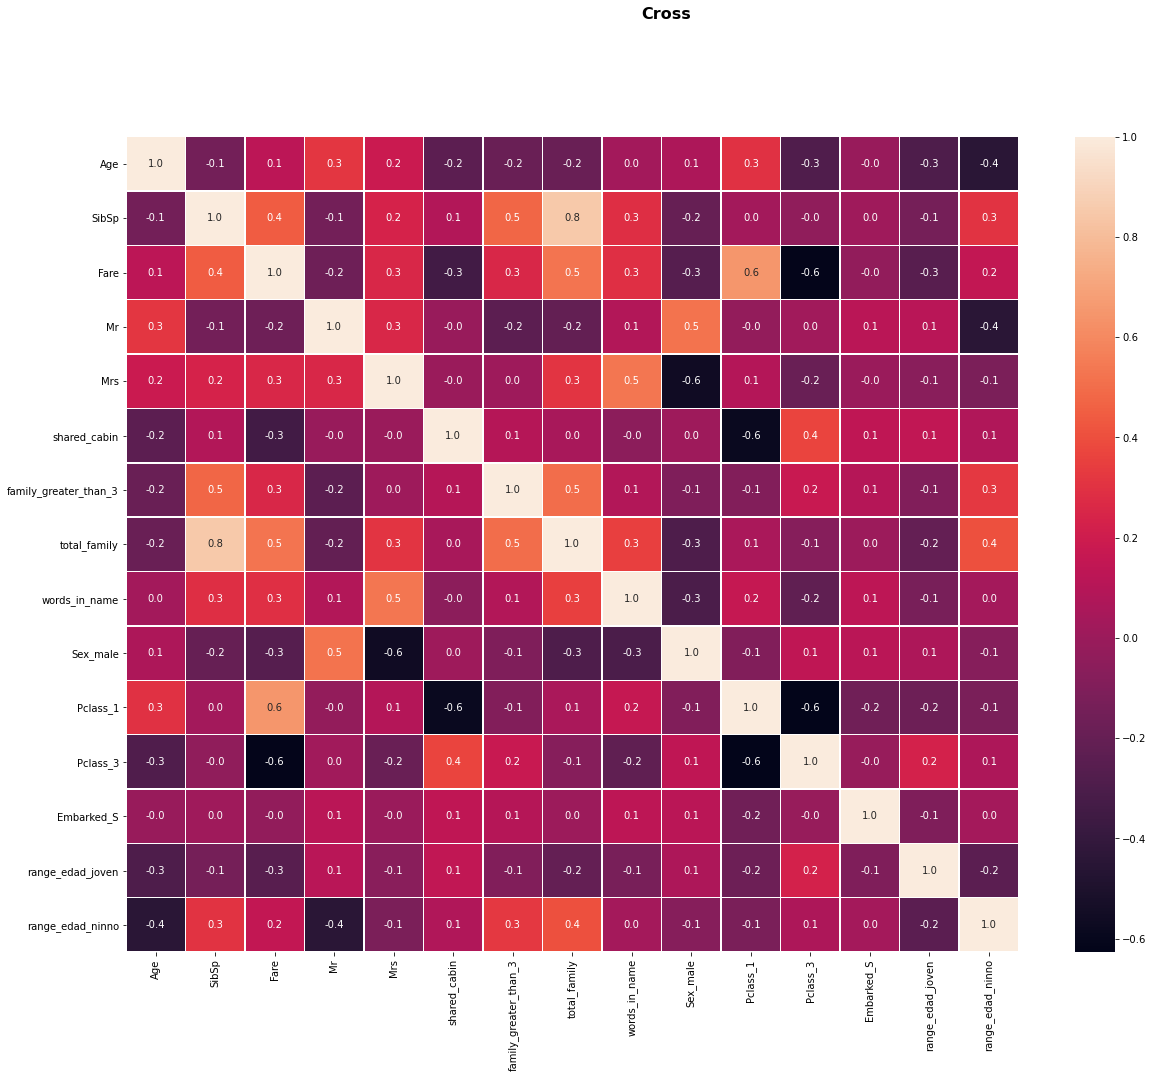

In [57]:
f,ax = plt.subplots(figsize=(20, 15))
g = sns.heatmap(df_train.corr(method = 'spearman'),
            annot=True, linewidths=.5, fmt= '.1f', ax=ax)
plt.suptitle("Cross",
               fontsize=16, weight="bold", y=1)

In [58]:
df_train.shape, df_test.shape

((891, 15), (418, 15))

In [59]:
columns_final = list(df_test.columns)
len(columns_final)

15

In [60]:
df_train = df_train[columns_final]

df_train.shape, df_test.shape

((891, 15), (418, 15))

# 6. Implementación de Algorimo de Machine Learning

In [61]:
from numpy import loadtxt
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

In [62]:
X = df_train
Y = train_data[target]

In [63]:
X_test_noNull = df_test

Grid Search

In [64]:
from sklearn.model_selection import RandomizedSearchCV
# Number of trees in random forest
n_estimators = [int(x) for x in range(50, 1001, 50)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in range(2,8)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10, 30, 50, 100, 150]
# Minimum number of samples required at each leaf node
min_samples_leaf = [2, 5, 10, 30, 50, 100, 150]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Class Weigth
balanced = [None, 'balanced', 'balanced_subsample']
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap,
               'class_weight': balanced}
print(random_grid)

{'n_estimators': [50, 100, 150, 200, 250, 300, 350, 400, 450, 500, 550, 600, 650, 700, 750, 800, 850, 900, 950, 1000], 'max_features': ['auto', 'sqrt'], 'max_depth': [2, 3, 4, 5, 6, 7, None], 'min_samples_split': [2, 5, 10, 30, 50, 100, 150], 'min_samples_leaf': [2, 5, 10, 30, 50, 100, 150], 'bootstrap': [True, False], 'class_weight': [None, 'balanced', 'balanced_subsample']}


In [65]:
# Use the random grid to search for best hyperparameters
# First create the base model to tune
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier()
# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 100, cv = 3, verbose=2, random_state=42, n_jobs = -1)
# Fit the random search model
rf_random.fit(X, Y)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:   12.5s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:  2.3min finished


RandomizedSearchCV(cv=3, estimator=RandomForestClassifier(), n_iter=100,
                   n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'class_weight': [None, 'balanced',
                                                         'balanced_subsample'],
                                        'max_depth': [2, 3, 4, 5, 6, 7, None],
                                        'max_features': ['auto', 'sqrt'],
                                        'min_samples_leaf': [2, 5, 10, 30, 50,
                                                             100, 150],
                                        'min_samples_split': [2, 5, 10, 30, 50,
                                                              100, 150],
                                        'n_estimators': [50, 100, 150, 200, 250,
                                                         300, 350, 400, 450,
                                                         50

In [66]:
# Mejores parametros
rf_random.best_params_

{'n_estimators': 800,
 'min_samples_split': 30,
 'min_samples_leaf': 2,
 'max_features': 'auto',
 'max_depth': None,
 'class_weight': None,
 'bootstrap': False}

Volvemos al modelo

In [67]:
## Random Forest
from sklearn.ensemble import RandomForestClassifier
model_rf = RandomForestClassifier(n_estimators=800,
                                  min_samples_split = 5,
                                  min_samples_leaf = 5,
                                  max_features = 'auto',
                                  max_depth = 5,
                                  random_state = 49,
                                  bootstrap = True,
                                  class_weight='balanced')
model_rf.fit(X, Y)

RandomForestClassifier(class_weight='balanced', max_depth=5, min_samples_leaf=5,
                       min_samples_split=5, n_estimators=800, random_state=49)

In [68]:
y_pred_train = model_rf.predict(X)

In [69]:
from sklearn import metrics as metrics
# Matriz de confusion
print("Matriz confusion: Train")
cm_train = metrics.confusion_matrix(Y,y_pred_train)
print(cm_train)

# Accuracy
print("Accuracy: Train")
accuracy_train=metrics.accuracy_score(Y,y_pred_train)
print(accuracy_train)

# Precision
print("Precision: Train")
precision_train=metrics.precision_score(Y,y_pred_train)
print(precision_train)

# Recall
print("Recall: Train")
recall_train=metrics.recall_score(Y,y_pred_train)
print(recall_train)

# ROC_AUC
print("ROC-AUC: Train")
recall_train=metrics.roc_auc_score(Y,y_pred_train)
print(recall_train)

Matriz confusion: Train
[[485  64]
 [ 77 265]]
Accuracy: Train
0.8417508417508418
Precision: Train
0.8054711246200608
Recall: Train
0.7748538011695907
ROC-AUC: Train
0.8291391045920813


In [70]:
#print(classification_report(Y,y_pred_train))

In [71]:
# RandomForest
y_pred = model_rf.predict(X_test_noNull)
output = pd.DataFrame({'PassengerId': PassengerId_test, 'Survived': y_pred})
output.to_csv('my_submission.csv', index=False)
print("Your submission was successfully saved!")

Your submission was successfully saved!
